In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [3]:
df1 = df = pd.read_csv('/content/drive/MyDrive/Datasets/Insurance_claims_Final.csv')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cleaning data

In [4]:
df1['LossDate'] = pd.to_datetime(df1['LossDate'], infer_datetime_format=True)
df1['LossDate'] = df1['LossDate'].dt.strftime('%d-%m-%Y')
df1['FirstPolicySubscriptionDate'] = pd.to_datetime(df1['FirstPolicySubscriptionDate'], infer_datetime_format=True)
df1['FirstPolicySubscriptionDate'] = df1['FirstPolicySubscriptionDate'].dt.strftime('%d-%m-%Y')

In [5]:
df1['days_diff'] = (pd.to_datetime(df1['LossDate'], format='%d-%m-%Y') - pd.to_datetime(df1['FirstPolicySubscriptionDate'], format='%d-%m-%Y')).dt.days
df1['days_diff']

0         198
1         552
2         696
3         711
4         354
         ... 
11525     705
11526    1326
11527     166
11528     799
11529    1473
Name: days_diff, Length: 11530, dtype: int64

In [6]:
df1.PolicyholderOccupation = pd.Categorical(df1.PolicyholderOccupation).codes
df1.ClaimCause = pd.Categorical(df1.ClaimCause).codes
df1.ClaimInvolvedCovers = pd.Categorical(df1.ClaimInvolvedCovers).codes
df1.FirstPartyVehicleType = pd.Categorical(df1.FirstPartyVehicleType).codes
df1.PolicyHolderPostCode = pd.Categorical(df1.PolicyHolderPostCode).codes

In [7]:
#There were string values in the code which is changed to nan values
for i in range(len(df1)):
    if isinstance(df1.loc[i, 'LossPostCode'], str) and not df1.loc[i, 'LossPostCode'].isnumeric():
        df1.loc[i, 'LossPostCode'] = np.nan
    else:
        df1.loc[i, 'LossPostCode'] = float(df1.loc[i, 'LossPostCode'])

In [8]:
#Nan values are changed to 0
df1[['LossPostCode']] = df1[['LossPostCode']].fillna(0)

In [9]:
df1 = df1.drop(['LossDate' , 'FirstPolicySubscriptionDate'] , axis=1)
df1[['FirstPartyVehicleNumber', 'LossPostCode']] = df1[['FirstPartyVehicleNumber', 'LossPostCode']].fillna(0)

In [10]:
# Mean for nan values in LossHour and PolicyHolderAge columns
df1[['LossHour', 'PolicyHolderAge' , 'FpVehicleAgeMonths']] = df1[['LossHour', 'PolicyHolderAge' , 'FpVehicleAgeMonths']].fillna(df1[['LossHour', 'PolicyHolderAge' , 'FpVehicleAgeMonths']].mean())

In [11]:
# Dropping columns
df1 = df1.drop(['ThirdPartyVehicleNumber', 'InsurerNotes', 'DamageImportance' , 'ConnectionBetweenParties'], axis=1)

In [12]:
# Filling low nan values column with mode
df1['FirstPartyVehicleType'].fillna(df1['FirstPartyVehicleType'].mode()[0], inplace=True)

In [13]:
constant=1
df1['claim_amount_log'] = np.log(df1['ClaimAmount'] + constant)
print(df1.head())

   ReferenceId  PolicyholderNumber  FirstPartyVehicleNumber  \
0         4842              531112                 715507.0   
1         4844               87170                  71164.0   
2         4848               98706                 442609.0   
3         4849               38240                  24604.0   
4         4850               11339                   2933.0   

   PolicyholderOccupation  ClaimCause  ClaimInvolvedCovers  \
0                       0           3                   36   
1                      10          10                   36   
2                      10           1                   36   
3                       0           1                   44   
4                       3           1                   12   

   FirstPartyVehicleType  LossPostCode  PolicyHolderPostCode  \
0                      0       31330.0                   744   
1                      0       29810.0                   606   
2                      0       33500.0                  

In [14]:
# Dropping columns
df1 = df1.drop(['ClaimAmount'], axis=1)

In [15]:
df1.fillna(0, inplace=True)

Question 6(a)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create a mask for non-fraudulent claims
non_fraud_mask = (df1['Fraud'] == False)

# Create the training set using only non-fraudulent claims
train_set = df1[non_fraud_mask]

# Create a mask for fraudulent claims
fraud_mask = (df1['Fraud'] == True)

# Split the fraudulent claims evenly between validation and test sets
fraud_indices = list(df1[fraud_mask].index)
fraud_val_indices, fraud_test_indices = train_test_split(fraud_indices, test_size=0.5, random_state=42)

# Create the validation set using both non-fraudulent and fraudulent claims
val_set = pd.concat([df1[non_fraud_mask], df1.loc[fraud_val_indices]])

# Create the test set using both non-fraudulent and fraudulent claims
test_set = pd.concat([df1[non_fraud_mask], df1.loc[fraud_test_indices]])

# Confirm the number of non-fraudulent and fraudulent claims in each set
print(f"Train set size: {len(train_set)}, non-fraudulent: {len(train_set[train_set['Fraud'] == False])}, fraudulent: {len(train_set[train_set['Fraud'] == True])}")
print(f"Validation set size: {len(val_set)}, non-fraudulent: {len(val_set[val_set['Fraud'] == False])}, fraudulent: {len(val_set[val_set['Fraud'] == True])}")
print(f"Test set size: {len(test_set)}, non-fraudulent: {len(test_set[test_set['Fraud'] == False])}, fraudulent: {len(test_set[test_set['Fraud'] == True])}")


Train set size: 11415, non-fraudulent: 11415, fraudulent: 0
Validation set size: 11472, non-fraudulent: 11415, fraudulent: 57
Test set size: 11473, non-fraudulent: 11415, fraudulent: 58


Extracting X,Y from the split data

In [17]:
feature_cols = df1.drop('Fraud', axis=1).columns
target_col = 'Fraud'

# Split each set into features and target
x_train, y_train = train_set[feature_cols], train_set[target_col]
x_val, y_val = val_set[feature_cols], val_set[target_col]
x_test, y_test = test_set[feature_cols], test_set[target_col]

# Confirm the shape of the feature and target sets
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (11415, 20), y_train shape: (11415,)
x_val shape: (11472, 20), y_val shape: (11472,)
x_test shape: (11473, 20), y_test shape: (11473,)


Training set MSE- where we got NaN

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Create a mask for non-fraudulent claims
non_fraud_mask = (df1['Fraud'] == False)

# Create the training set using only non-fraudulent claims
train_set = df1[non_fraud_mask]

# Normalize the training set
train_set_norm = (train_set - train_set.mean()) / train_set.std()

# Define the autoencoder architecture
input_dim = len(train_set.columns)
encoding_dim = 32

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder with mean squared error (MSE) loss
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Convert the normalized training set to a TensorFlow tensor
train_set_norm_tensor = tf.convert_to_tensor(train_set_norm.values, dtype=tf.float32)

# Train the autoencoder on the normalized training set tensor
autoencoder.fit(train_set_norm_tensor, train_set_norm_tensor, epochs=50, batch_size=128, shuffle=True, validation_split=0.2)

# Use the trained autoencoder to reconstruct the training set and calculate the MSE
train_set_reconstructed = autoencoder.predict(train_set_norm_tensor)
mse = np.mean(np.square(train_set_norm_tensor - train_set_reconstructed))

# Print the MSE
print(f"Training set MSE: {mse}")


Epoch 1/50
72/72 [==============================] - 1s 6ms/step - loss: nan - val_loss: nan
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 7/50
72/72 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 8/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 9/50
72/72 [==============================] - 0s 3ms/step - loss: nan - val_loss: nan
Epoch 10/50
72/72 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 11/50
72/72 [==============================] - 0s 3ms/step - loss: nan - 

Question 6(b), (c), (d), (e), (f)

In [19]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(x_train.shape[1:][0], activation="relu", input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(6, activation="relu"),])


In [20]:
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(x_train.shape[1:][0], activation="sigmoid")])

In [21]:
autoencoder = tf.keras.Sequential([encoder,decoder])

In [22]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 6)                 2046      
                                                                 
 sequential_1 (Sequential)   (None, 20)                1682      
                                                                 
Total params: 3,728
Trainable params: 3,728
Non-trainable params: 0
_________________________________________________________________


In [23]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 60)                1260      
                                                                 
 dense_4 (Dense)             (None, 6)                 366       
                                                                 
Total params: 2,046
Trainable params: 2,046
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.compile(optimizer='rmsprop',
                    loss='mean_squared_error')

In [25]:
# Normalize the data
train_set_mean = train_set.mean()
train_set_std = train_set.std()
train_data = (train_set - train_set_mean) / train_set_std
val_data = (val_set - train_set_mean) / train_set_std
test_data = (test_set - train_set_mean) / train_set_std


In [28]:
#Fitting autoencoder
autoencoder.fit(x=x_train, y=x_train,
                epochs=10, batch_size=64,
                validation_data=(x_val, x_val))

Epoch 1/10
179/179 [==============================] - 1s 6ms/step - loss: 41467617280.0000 - val_loss: 41503903744.0000
Epoch 2/10
179/179 [==============================] - 1s 4ms/step - loss: 41467625472.0000 - val_loss: 41503903744.0000
Epoch 3/10
179/179 [==============================] - 1s 3ms/step - loss: 41467621376.0000 - val_loss: 41503903744.0000
Epoch 4/10
179/179 [==============================] - 1s 4ms/step - loss: 41467629568.0000 - val_loss: 41503903744.0000
Epoch 5/10
179/179 [==============================] - 1s 4ms/step - loss: 41467621376.0000 - val_loss: 41503903744.0000
Epoch 6/10
179/179 [==============================] - 1s 4ms/step - loss: 41467609088.0000 - val_loss: 41503903744.0000
Epoch 7/10
179/179 [==============================] - 1s 4ms/step - loss: 41467596800.0000 - val_loss: 41503903744.0000
Epoch 8/10
179/179 [==============================] - 1s 4ms/step - loss: 41467613184.0000 - val_loss: 41503903744.0000
Epoch 9/10
179/179 [====================

In [29]:
#Evaluating model
test_loss = autoencoder.evaluate(x_test, x_test)
print(f"Reconstruction loss on test set: {test_loss}")


359/359 [==============================] - 1s 1ms/step - loss: 41470365696.0000
Reconstruction loss on test set: 41470365696.0


In [30]:
# Predict the encoded representation of the input data
encoded_data = encoder.predict(x_test)
# Decode the encoded representation back to the original input data
decoded_data = decoder.predict(encoded_data)


359/359 [==============================] - 1s 1ms/step


In [31]:
val_data = val_set.drop(columns=['Fraud']).to_numpy()


359/359 [==============================] - 1s 2ms/step


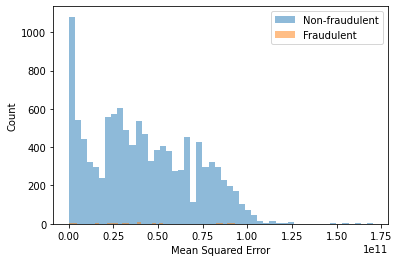

In [32]:
# Predict on validation set
val_predictions = autoencoder.predict(val_data)

# Calculate mean squared error for each example in the validation set
val_mse = np.mean(np.power(val_data - val_predictions, 2), axis=1)

# Create a mask for fraudulent claims in the validation set
val_fraud_mask = (val_set['Fraud'] == True)

# Plot the histogram of errors, distinguishing between fraudulent and non-fraudulent claims
plt.hist(val_mse[~val_fraud_mask], bins=50, alpha=0.5, label='Non-fraudulent')
plt.hist(val_mse[val_fraud_mask], bins=50, alpha=0.5, label='Fraudulent')
plt.legend(loc='upper right')
plt.xlabel('Mean Squared Error')
plt.ylabel('Count')
plt.show()


In [33]:
def preprocess(data):
    # Subtract the mean and divide by the standard deviation of each feature
    return (data - data.mean(axis=0)) / data.std(axis=0)


In [36]:
from keras.models import Sequential

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# Define a function to create the autoencoder model
def create_autoencoder_model(optimizer='adam', activation='relu', hidden_layers=1, neurons=64, dropout_rate=0.0, input_dim=8):
    encoder = Sequential()
    encoder.add(Dense(neurons, input_dim=input_dim, activation=activation))
    for i in range(hidden_layers-1):
        encoder.add(Dense(neurons, activation=activation))
        encoder.add(Dropout(dropout_rate))
    encoder.add(Dense(6, activation="relu"))
    decoder = Sequential()
    decoder.add(Dense(60, activation="relu", input_shape=(6,)))
    decoder.add(Dense(x_train.shape[1:][0], activation="sigmoid"))
    autoencoder = Sequential([encoder,decoder])
    autoencoder.compile(optimizer=optimizer,
                        loss='mean_squared_error')
    return autoencoder
# Define the hyperparameters to search over
params = {'optimizer': ['sgd', 'adam', 'rmsprop'],
          'activation': ['relu', 'sigmoid'],
          'hidden_layers': [1, 2, 3],
          'neurons': [32, 64, 128],
          'dropout_rate': [0.0, 0.2, 0.4]}
# Create the KerasRegressor model
model = KerasRegressor(build_fn=create_autoencoder_model, input_dim=x_train.shape[1], epochs=10, batch_size=64, verbose=0)
# Use GridSearchCV to search for the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, x_train)
# Print the best hyperparameters and validation score
print(f"Best score: {grid_result.best_score_:.4f}")
print(f"Best parameters: {grid_result.best_params_}")

<ipython-input-37-54695ebfedcf>:29: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_autoencoder_model, input_dim=x_train.shape[1], epochs=10, batch_size=64, verbose=0)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score: -41467613184.0000
Best parameters: {'activation': 'relu', 'dropout_rate': 0.0, 'hidden_layers': 1, 'neurons': 128, 'optimizer': 'adam'}


In [38]:
# Get the best model
best_model = grid_result.best_estimator_

# Use the best model to make predictions on new data
y_pred = best_model.predict(x_test)

In [39]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(x_test, y_pred)
print(f"MSE: {mse:.4f}")


MSE: 41470430645.2558


In [40]:
# Set the threshold for classification
threshold = 0.2

# Calculate the mean squared error between the predicted and actual test data
mse = mean_squared_error(x_test, y_pred)

# Classify the predictions as good or bad based on the threshold
if mse <= threshold:
    print("Non-Fraudulent")
else:
    print("Fraudulent")


Fraudulent


In [43]:
# Set the threshold for classification
threshold = 0.1

# Calculate the mean squared error between the predicted and actual test data
mse = mean_squared_error(x_test, y_pred)

# Classify the predictions as good or bad based on the threshold
predictions = (mse <= threshold).astype(int)

# Calculate the hit rate and detection rate
true_positives = np.sum(np.logical_and(predictions == 1, y_test == 1))
false_negatives = np.sum(np.logical_and(predictions == 0, y_test == 1))
false_positives = np.sum(np.logical_and(predictions == 1, y_test == 0))

hit_rate = true_positives / (true_positives + false_negatives)

if (true_positives + false_positives) == 0:
    detection_rate = 0.0
else:
    detection_rate = true_positives / (true_positives + false_positives)

print(f"Hit rate: {hit_rate*100:.2f}%")
print(f"Detection rate: {detection_rate*100:.2f}%")


Hit rate: 0.00%
Detection rate: 0.00%
